<a href="https://colab.research.google.com/github/Lotaristo/Projects/blob/main/SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Лабораторная работа №3

ОТЛИЧНО! СПАСИБО ЗА РАБОТУ!


1) в вашей предварительно созданной схеме (schema) в базе данных из
лабораторной работы №1 и наличия внешней таблицы (FOREIGN TABLE) из
лабораторной работы №2, создайте следующие функции

    a)  
    имя: get_data_by_avg_cheque
    тип: plpgSQL
    входящий параметр: p_average NUMERIC
    тип входящего параметра: IN
    возвращаемое значение: набор строк со всеми столбцами из внешней таблицы.
    логика функции: вывести строки, со значение поля “Средний чек, тыс.руб.” больше ( >) p_average рублей

    b)
    имя: get_data_by_month_shop
    тип: SQL
    входящий параметр: p_month VARCHAR, p_shop INTEGER
    типы входящих параметров: IN
    возвращаемое значение: набор строк со всеми столбцами из внешней
    таблицы
    логика функции: вывести строки из данных с переданными фильтрами
    по месяцу (p_month) и по магазину (p_shop). Если передается пустое
    значение для p_month - то выводить все месяцы, если передается пустое
    значение для p_shop - то выводить все магазины. Если передаются оба
    параметры пустыми - то выводить все из таблицы. Результат
    упорядочить по категории

Прикладываемый артефакт к работе: DDL команда создания обеих функций
скриншоты результатов возвращаемых первых 20 строк данных при обращении
к функциям через SELECT * FROM … .

#### Задание 1.а

In [ ]:
CREATE OR REPLACE FUNCTION meyerczeslaw.get_data_by_avg_cheque(p_average NUMERIC)
RETURNS TABLE (
    month TEXT,
    quarter INT,
    store_id INT,
    product_category TEXT,
    average_receipt NUMERIC,
    receipt_count NUMERIC
) AS $$
BEGIN
    RETURN QUERY
    SELECT
        sd.month,
        sd.quarter,
        sd.store_id,
        sd.product_category,
        REPLACE(sd.average_receipt, ',', '.')::NUMERIC(10, 2) AS average_receipt,
        sd.receipt_count
    FROM
        meyerczeslaw.sales_data AS sd
    WHERE
        REPLACE(sd.average_receipt, ',', '.')::NUMERIC > p_average;
END;
$$ LANGUAGE plpgsql;

SELECT * FROM meyerczeslaw.get_data_by_avg_cheque(10) ORDER BY 5 DESC LIMIT 20;

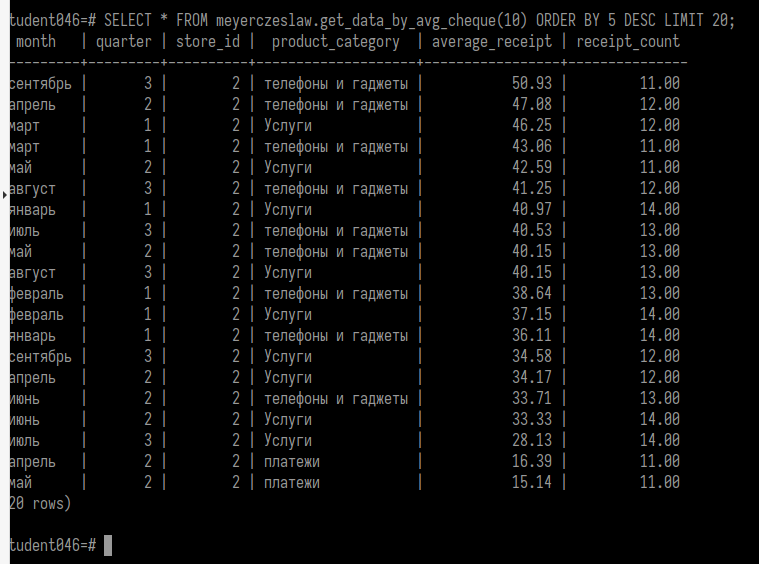

#### Задание 1.b

In [ ]:
CREATE OR REPLACE FUNCTION meyerczeslaw.get_data_by_month_shop(p_month VARCHAR, p_shop INTEGER)
RETURNS TABLE (
    month TEXT,
    quarter INT,
    store_id INT,
    product_category TEXT,
    average_receipt NUMERIC,
    receipt_count NUMERIC
) AS $$
BEGIN
    RETURN QUERY
    SELECT
        sd.month,
        sd.quarter,
        sd.store_id,
        sd.product_category,
        REPLACE(sd.average_receipt, ',', '.')::NUMERIC(10, 2) AS average_receipt,
        sd.receipt_count
    FROM
        meyerczeslaw.sales_data AS sd
    WHERE
        (p_month IS NULL OR sd.month = p_month)
        AND
        (p_shop IS NULL OR sd.store_id = p_shop);
END;
$$ LANGUAGE plpgsql;


In [ ]:
SELECT * FROM meyerczeslaw.get_data_by_month_shop(NULL, 1) ORDER BY 1 LIMIT 20;

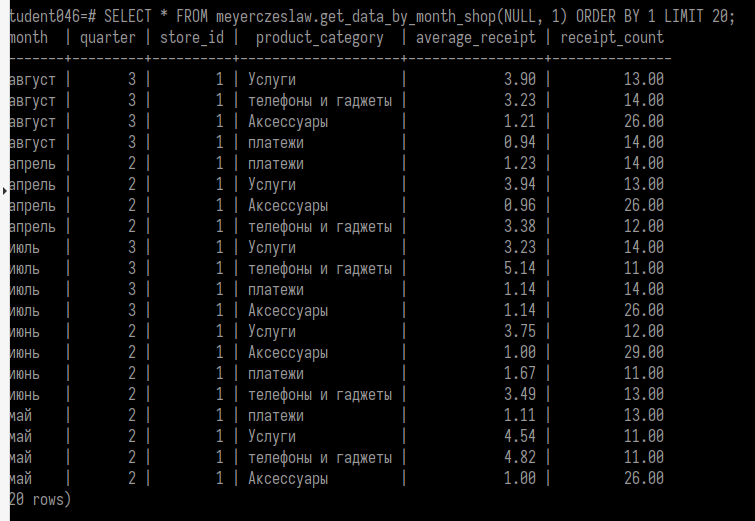

In [ ]:
SELECT * FROM meyerczeslaw.get_data_by_month_shop('январь', NULL) ORDER BY 3 LIMIT 20;

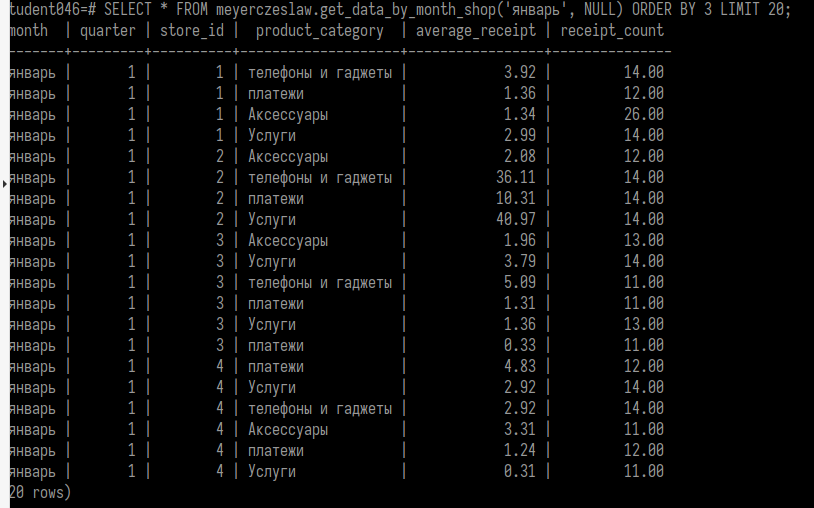

In [ ]:
SELECT * FROM meyerczeslaw.get_data_by_month_shop(NULL, NULL) LIMIT 20;

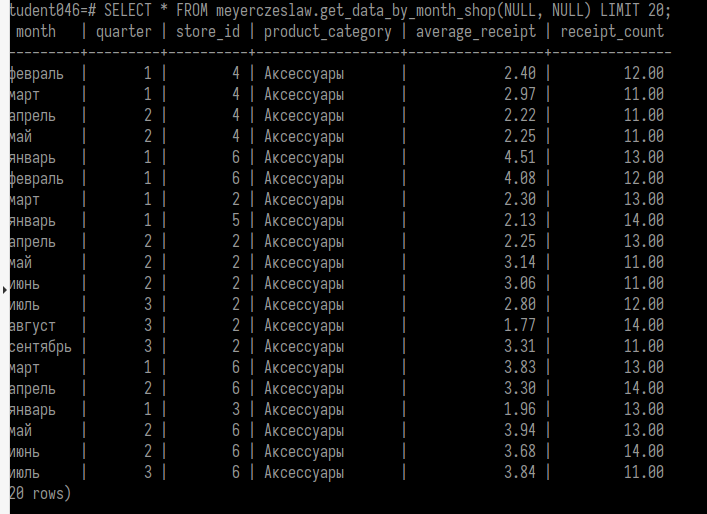

### Промежуточная аттестация №1

1) всю работу необходимо провести в вашей предварительно созданной схеме
(schema) в базе данных

Необходимо создать таблицу main_table с полями
- id INTEGER
- name VARCHAR
- s_date DATE

Создайте триггер для перехвата событий BEFORE INSERT с созданием
наследуемой таблицы (inherited table) и с использованием динамического SQL
и перенаправлением NEW состояния поступающей записи во вновь созданную
таблицу.
Наследуемая таблица должна создаваться на-лету на основании
значения поля s_date по следующему шаблону имени: main_table_20240401,
где 2024.04.01 - дата поступающая в значении NEW записи.
Если данная наследуемая таблица уже создана предыдущими INSERT
выражениями в родительскую таблицу - то необходимо только перенаправить
NEW состояние поступающей записи в уже существующую таблицу
Протестируйте следующие SQL запросы

    INSERT INTO main_table(id, name, s_date) VALUES (1, ‘Иван’, ‘2024-01-01’);
    INSERT INTO main_table(id, name, s_date) VALUES (2, ‘Анна’, ‘2024-01-02’);
    INSERT INTO main_table(id, name, s_date) VALUES (3, ‘Сергей’, ‘2024-01-03’);
    INSERT INTO main_table(id, name, s_date) VALUES (4, ‘Екатерина’, ‘2024-01-02’);
В результате у вас динамически должны создаться 3 наследуемых таблицы и
SQL запрос ниже должен вернуть 0 строк!

    SELECT count(*) FROM ONLY main_table;

Прикладываемый артефакт к работе: DDL команда создания таблицы и
триггера. 3 скриншота результатов возвращаемых значений из каждой
наследуемой таблицы.


In [ ]:
DROP TABLE main_table CASCADE;

CREATE TABLE main_table (
    id INTEGER,
    name VARCHAR,
    s_date DATE);


In [ ]:
CREATE OR REPLACE FUNCTION handle_insert()
RETURNS TRIGGER AS $$
DECLARE
    table_name TEXT;
    existing_count INTEGER;
BEGIN
    table_name := 'main_table_' || TO_CHAR(NEW.s_date, 'YYYYMMDD');

    -- Проверка на наличие таблицы
    IF NOT EXISTS (SELECT 1 FROM pg_tables WHERE tablename = table_name)
    THEN
        EXECUTE format(
            'CREATE TABLE %I (CHECK (s_date = %L)) INHERITS (main_table)', table_name, NEW.s_date);
    END IF;

    -- Проверка на наличие записи (всегда активно)
    EXECUTE format(
        'SELECT COUNT(*) FROM %I WHERE s_date = $1', table_name)
    INTO existing_count USING NEW.s_date;

    -- Замена имени и id
    IF existing_count > 0 THEN
        EXECUTE format(
            'UPDATE %I SET id = $1, name = $2 WHERE s_date = $3', table_name)
        USING NEW.id, NEW.name, NEW.s_date;
    ELSE
    -- Вставка новой записи, если нет
        EXECUTE format(
            'INSERT INTO %I (id, name, s_date) VALUES ($1, $2, $3)', table_name)
        USING NEW.id, NEW.name, NEW.s_date;
    END IF;

    RETURN NULL;
END;
$$ LANGUAGE plpgsql;


In [ ]:
CREATE TRIGGER before_insert_trigger
BEFORE INSERT ON main_table FOR EACH ROW
EXECUTE FUNCTION handle_insert();


In [ ]:
INSERT INTO main_table(id, name, s_date) VALUES (1, 'Иван', '2024-01-01');
INSERT INTO main_table(id, name, s_date) VALUES (2, 'Анна', '2024-01-02');
INSERT INTO main_table(id, name, s_date) VALUES (3, 'Сергей', '2024-01-03');
INSERT INTO main_table(id, name, s_date) VALUES (4, 'Екатерина', '2024-01-02');

SELECT count(*) FROM ONLY main_table;
SELECT * FROM main_table_20240101;
SELECT * FROM main_table_20240102;
SELECT * FROM main_table_20240103;


Очень долго мучался, и не уверен, насколько мое решение правильно (во второй таблицы постоянно Екатерина добавлялась второй записью, вместо того чтобы менять первую, каким-то образом дошел до проверки записи по дате, и вроде получилось).
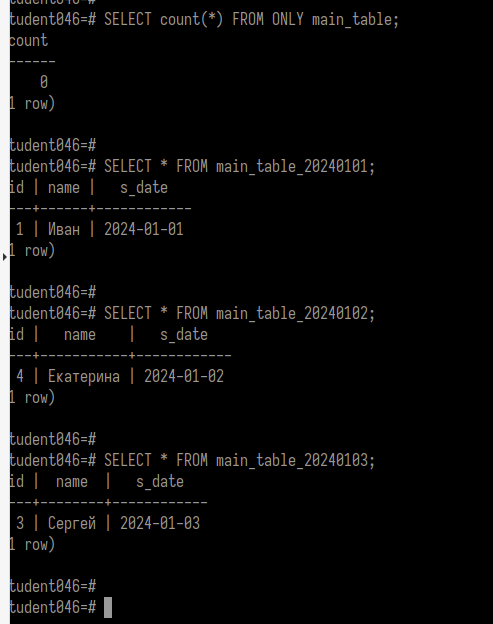

### Лабораторная работа №4

1) в вашей предварительно созданной схеме (schema) в базе данных из
лабораторной работы №1 примените скрипт по созданию таблиц и заполнению
их данными.

ВНИМАНИЕ! Предварительно скрипт модернизируйте в редакторе так, чтобы
таблицы создавались в вашей схеме. Например, из SQL команды

    create table college
    (
    id bigint primary key ,
    name varchar not null ,
    size integer not null default 100
    );

в команду

    create table ваша_схема.college
    (
    id bigint primary key ,
    name varchar not null ,
    size integer not null default 100
    );

Решите следующие SQL запросы:

    - Напишите SQL запрос который возвращает имена студентов и их аккаунт
    в Telegram у которых родной город “Казань” или “Москва”. Результат
    отсортируйте по имени студента в убывающем порядке
    - Напишите SQL запрос который возвращает название online курсов
    университетов и количество заявленных слушателей. Количество
    заявленных слушателей на курсе должно быть в диапазоне от 27 до 310
    студентов. Результат отсортируйте по названию курса и по количеству
    заявленных слушателей в убывающем порядке для двух полей.
    - Напишите SQL запрос который возвращает список университетов и
    количество студентов, если идентификатор университета НЕ должен
    соответствовать значениям из списка 10, 30, 50. Пожалуйста в основе
    примените конструкцию IN. Результат запроса отсортируйте по
    количеству студентов И затем по наименованию университета.
    - Напишите SQL запрос который возвращает данные по университетам в
    следующем виде (один столбец со всеми данными внутри) с сортировкой
    по полю “полная информация”
    - Напишите SQL запрос который возвращает название курса и количество
    заявленных студентов в отсортированном списке по количеству
    слушателей в возрастающем порядке, НО запись с количеством
    слушателей равным 300 должна быть на первом месте. Ограничьте
    вывод данных до 3 строк. Пример результата представлен ниже

Прикладываемый артефакт к работе: SQL команды, решающие 5 задач и
скриншот результата для каждой команды который у вас получился.



In [ ]:
-- Скрипт

create table meyerczeslaw.college
(
    id bigint primary key,
    name varchar not null,
    size integer not null default 100
);

insert into meyerczeslaw.college(id, name, size) values (10, 'КФУ',50000);
insert into meyerczeslaw.college(id, name, size) values (20, 'МГУ',38000);
insert into meyerczeslaw.college(id, name, size) values (30, 'МФТИ',7000);
insert into meyerczeslaw.college(id, name, size) values (40, 'Иннополис',1077);
insert into meyerczeslaw.college(id, name, size) values (50, 'Сколково',1070);

create table meyerczeslaw.student
(
    id bigint primary key,
    city varchar not null,
    name varchar not null,
    telegram_contact varchar not null,
    college_id bigint not null,
    constraint fk_college_id foreign key (college_id) references meyerczeslaw.college(id)
);

insert into meyerczeslaw.student(id, city, name, telegram_contact, college_id) values (10, 'Казань','Иван Иванов','@ivanov1991',10);
insert into meyerczeslaw.student(id, city, name, telegram_contact, college_id) values (20, 'Москва','Екатерина Андреева','@kate_',20);
insert into meyerczeslaw.student(id, city, name, telegram_contact, college_id) values (30, 'Новосибирск','Анна Потапова','@apotap',30);
insert into meyerczeslaw.student(id, city, name, telegram_contact, college_id) values (40, 'Казань','Ильяс Мухаметшин','@ilyas',40);
insert into meyerczeslaw.student(id, city, name, telegram_contact, college_id) values (50, 'Москва','Сергей Петров','@spetrov',50);

create table meyerczeslaw.course
(
    id bigint primary key,
    name varchar not null,
    is_online boolean not null default false,
    amount_of_students integer check (amount_of_students >= 1),
    college_id bigint not null,
    constraint fk_course_college_id foreign key (college_id) references meyerczeslaw.college(id)
);

insert into meyerczeslaw.course(id, name, is_online, amount_of_students, college_id) values (10,'Введение в РСУБД', true, 300 , 10);
insert into meyerczeslaw.course(id, name, is_online, amount_of_students, college_id) values (20,'Data Mining', true, 10 , 20);
insert into meyerczeslaw.course(id, name, is_online, amount_of_students, college_id) values (30,'Нейронные сети', true, 25 , 30);
insert into meyerczeslaw.course(id, name, is_online, amount_of_students, college_id) values (40,'Цифровая трансформация', true, 50 , 40);
insert into meyerczeslaw.course(id, name, is_online, amount_of_students, college_id) values (50,'Актерское мастерство', false, 15 , 50);

create table meyerczeslaw.student_on_course
(
    id bigint primary key,
    student_id bigint not null,
    course_id bigint not null,
    student_rating integer not null default 50 check (student_rating between 0 and 100),
    finished_date date,
    constraint fk_student_id foreign key (student_id) references meyerczeslaw.student(id),
    constraint fk_course_id foreign key (course_id) references meyerczeslaw.course(id)
);вв

insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (10,10,10,75, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (20,10,20,83, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (30,10,40,40, null);

insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (40,20,50,95, '2022-12-12');

insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (50,30,30,76, '2022-12-12');
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (60,30,40,42, null);

insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (70,40,10,76, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (80,40,20,83, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (90,40,50,96, null);

insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (100,50,10,12, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (110,50,20,21, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (120,50,30,56, null);
insert into meyerczeslaw.student_on_course(id, student_id, course_id, student_rating, finished_date) VALUES (130,50,40,92, null);


Напишите SQL запрос который возвращает имена студентов и их аккаунт
в Telegram у которых родной город “Казань” или “Москва”. Результат
отсортируйте по имени студента в убывающем порядке


In [ ]:
SELECT name, telegram_contact
FROM meyerczeslaw.student
WHERE city IN ('Казань', 'Москва')
ORDER BY name DESC;


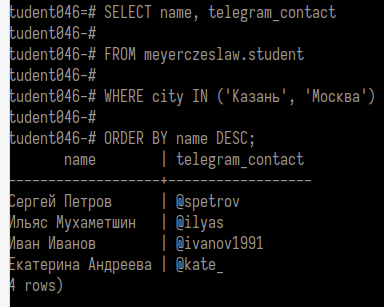

Напишите SQL запрос который возвращает название online курсов
университетов и количество заявленных слушателей. Количество
заявленных слушателей на курсе должно быть в диапазоне от 27 до 310
студентов. Результат отсортируйте по названию курса и по количеству
заявленных слушателей в убывающем порядке для двух полей.


In [ ]:
SELECT name, amount_of_students
FROM meyerczeslaw.course
WHERE is_online = true AND amount_of_students BETWEEN 27 AND 310
ORDER BY name DESC, amount_of_students DESC;


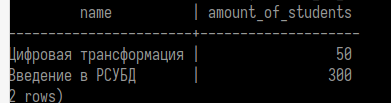

Напишите SQL запрос который возвращает список университетов и
количество студентов, если идентификатор университета НЕ должен
соответствовать значениям из списка 10, 30, 50. Пожалуйста в основе
примените конструкцию IN. Результат запроса отсортируйте по
количеству студентов И затем по наименованию университета

In [ ]:
SELECT name, size
FROM meyerczeslaw.college
WHERE id NOT IN (10, 30, 50)
ORDER BY size, name;


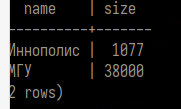

Напишите SQL запрос который возвращает данные по университетам в
следующем виде (один столбец со всеми данными внутри) с сортировкой
по полю “полная информация”

    полная информация
    университет: Иннополис; количество студентов: 1077
    университет: КФУ; количество студентов: 50000
    университет: МГУ; количество студентов: 38000


In [ ]:
SELECT 'университет: ' || name || '; количество студентов: ' || size AS "полная информация"
FROM meyerczeslaw.college
ORDER BY "полная информация";


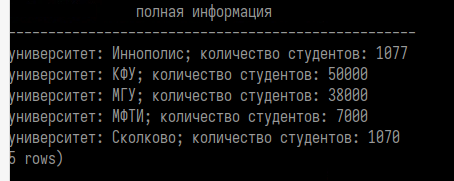

Напишите SQL запрос который возвращает название курса и количество
заявленных студентов в отсортированном списке по количеству
слушателей в возрастающем порядке, НО запись с количеством
слушателей равным 300 должна быть на первом месте. Ограничьте
вывод данных до 3 строк. Пример результата представлен ниже

    name amount_of_students
    Введение в РСУБД 300
    Data Mining 10
    Актерское мастерство 15

In [ ]:
SELECT name, amount_of_students
FROM meyerczeslaw.course
ORDER BY
    (amount_of_students = 300) DESC,
    amount_of_students ASC
LIMIT 3;


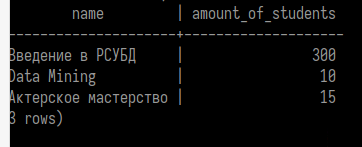

### Лаборатная работа №5

Импортируйте в вашу предварительно созданную схему (schema) в базе
данных, предоставленные данные о телеметрии оборудования.

Существует два файла

- приборы работающие в “зеленой зоне”. Значит никаких аварий на
производстве не выявлено

- те же самые приборы работающие в “красной зоне”. Значит есть
аномалия на производстве

ВНИМАНИЕ! Создайте 2 таблицы “сырых данных” для загрузки оригинальных
данных как они были предоставлены “as-is”. Последующие трансформации над
данными делайте в отдельных таблицах

Решите следующие SQL запросы:
- Загрузите сырые данные в ваши созданные таблицы в вашей схеме.
Заголовок (модель) данных обоих файлов выглядит следующим образом
    - внутренний номер устройства, отправляющий свое значение
    - дата высокой точности (UNIX_TIMESTAMP) получения значения
    от устройства
    - получаемое значение от устройства
- Создайте 2 новые таблицы со всеми оригинальными столбцами и
данными, но с трансформацией 2 столбца (необходимо формат
“1666202434173000” перевести в читаемую дату 2022-10-19 21:00:34.000 +0300 (тип timestamp) )
Подсказка: используйте функцию - to_timestamp
- Создайте виртуальную таблицу в вашей схеме данных, которая
“объединяет” данные двух таблиц из предыдущего пункта по всем
столбцам и с включением нового столбца указывающего какие данные в
красной или зеленой зоне находятся. Пример вывода ниже

    № прибора Дата Значение Зона
    1 2022-10-19 21:00:34.000 +0300 16588.29992 красная


In [ ]:
CREATE TABLE meyerczeslaw.greenzone_raw (
    device_id INTEGER,
    timestamp_unix BIGINT,
    value NUMERIC);

CREATE TABLE meyerczeslaw.redzone_raw (
    device_id INTEGER,
    timestamp_unix BIGINT,
    value NUMERIC);


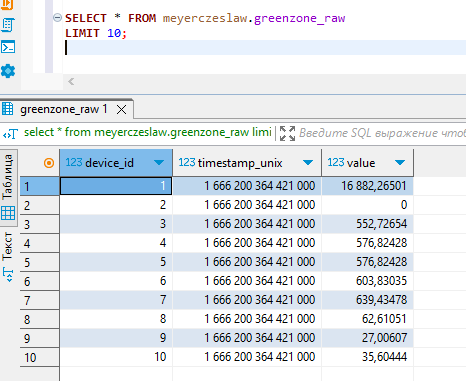

In [ ]:
CREATE TABLE meyerczeslaw.greenzone_transformed (
    device_id INTEGER,
    timestamp TIMESTAMP,
    value NUMERIC);

CREATE TABLE meyerczeslaw.redzone_transformed (
    device_id INTEGER,
    timestamp TIMESTAMP,
    value NUMERIC);


INSERT INTO meyerczeslaw.greenzone_transformed (device_id, timestamp, value)
SELECT device_id, to_timestamp(timestamp_unix / 1000000.0), value
FROM meyerczeslaw.greenzone_raw;

INSERT INTO meyerczeslaw.redzone_transformed (device_id, timestamp, value)
SELECT device_id, to_timestamp(timestamp_unix / 1000000.0), value
FROM meyerczeslaw.redzone_raw;


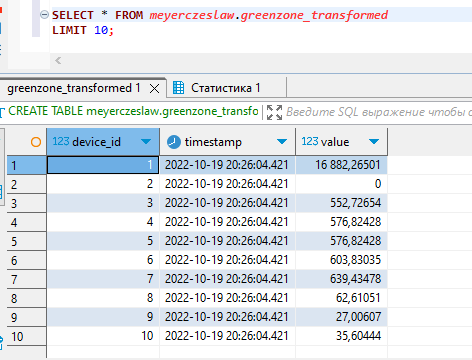

In [ ]:
CREATE VIEW meyerczeslaw.device_data_combined AS
SELECT
    device_id,
    timestamp,
    value,
    'зеленая' AS zone
FROM
    meyerczeslaw.greenzone_transformed
UNION ALL
SELECT
    device_id,
    timestamp,
    value,
    'красная' AS zone
FROM
    meyerczeslaw.redzone_transformed;


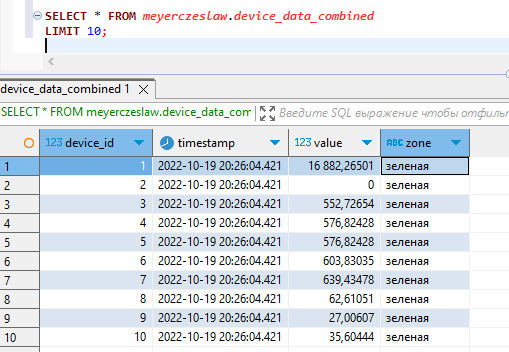

### Лаборатная работа №6

Решите следующие SQL запросы:

- Напишите SQL запрос который вернет имена студентов, курс на котором
они учатся, названия их родных университетов (в которых они
официально учатся) и соответствующий рейтинг по курсу. С условием
что рассматриваемый рейтинг студента должен быть строго больше (>)
50 баллов и размер соответствующего ВУЗа должен быть строго больше
(>) 5000 студентов. Результат необходимо отсортировать по первым двум
столбцам. Обратите внимание на часть ответа ниже с учетом
именования выходных атрибутов вашего запроса
- Выведите имена студентов и названия соответствующих учебных
курсов, которые преподаются в тех же университетах, в которых учатся
студенты. Результат необходимо отсортировать по первому столбцу
Обратите внимание на ответ ниже с учетом именования выходных
атрибутов вашего запроса

ВНИМАНИЕ! Решите данную задачу используя только соединения
NATURAL JOIN
- Выведите уникальные семантические пары студентов, родной город
которых один и тот же. Результат необходимо отсортировать по первому
столбцу. Семантически эквивалентная пара на основании одного города -
является пара студентов например (Иванов, Петров) = (Петров, Иванов),
в этом случае должна быть выведена одна из пар. Обратите внимание
на ответ ниже с учетом именования выходных атрибутов вашего
запроса

ВНИМАНИЕ! Решите данную задачу используя LATERAL JOIN


In [ ]:
SELECT
    s.name AS student_name,
    c.name AS course_name,
    col.name AS college_name,
    sc.student_rating AS course_rating
FROM
    meyerczeslaw.student s
JOIN
    meyerczeslaw.student_on_course sc ON s.id = sc.student_id
JOIN
    meyerczeslaw.course c ON sc.course_id = c.id
JOIN
    meyerczeslaw.college col ON s.college_id = col.id
WHERE
    sc.student_rating > 50
    AND col.size > 5000
ORDER BY
    student_name, course_name;


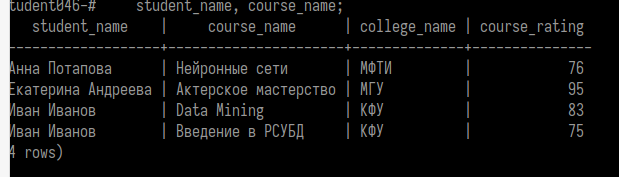

In [ ]:
SELECT s.name, c.name
FROM meyerczeslaw.student s
JOIN meyerczeslaw.course c on s.id = c.id;

SELECT s.name, c.name
FROM meyerczeslaw.student s
NATURAL JOIN meyerczeslaw.course c;


Не могу понять, как решить данную задачу. С обычным джойном все работает, но с NATURAL никак не идет. Пробовал по разному соединять, использовать вложенные запросы, разные таблицы, ничего не помогает.

In [ ]:
SELECT DISTINCT
    GREATEST(s1.name, s2.name) AS student_1,
    LEAST(s1.name, s2.name) AS student_2,
    s1.city AS city
FROM
    meyerczeslaw.student s1
JOIN LATERAL (
        SELECT s2.name, s2.city
        FROM meyerczeslaw.student s2
        WHERE s2.city = s1.city AND s2.id > s1.id
    ) AS s2 ON s1.city = s2.city
ORDER BY
    student_1;

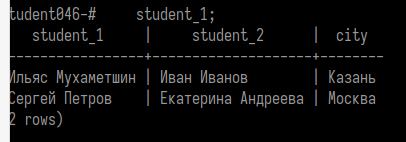

### Лаборатная работа №7


1) в вашу предварительно созданную схему (schema) в базе данных из
лабораторной работы №1 необходимо загрузить любые ВАШИ данные (для
этого можете подготовить формат csv из xls) или взять данные в открытом
доступе например на сайте kaggle.com

ВНИМАНИЕ! Не грузите персональные / чувствительные корпоративные
данные на учебный стенд!

ВНИМАНИЕ! Объем загружаемых данных не должен превышать 10 Мб!
Решите следующие задачи:

- подготовьте 3 любых OLAP запроса, которые раскрывают полезные
инсайты (Data Insight) из загруженных данных. Создайте 3 виртуальных
таблицы VIEW (или материализованных представления MATERIALZED
VIEW) в вашей схеме на основании ваших SQL OLAP запросов.
- создайте 3 отчета (chart) в предоставленном продукте RT.DataVision
(Superset) в формате визуализации, который по вашему мнению
раскроет ваш инсайт четче (Pie Chart, Histogram, Trends, GeoGraphics,
Chord Diagram, Radar Diagram, …). Предварительно создайте под своим
пользователем соединение к учебной базе данных PostgreSQL и дайте
этому соединению имя вашего пользователя.
- скомпонуйте три созданных отчета на одном дашборде (dashboard)

Прикладываемый артефакт к работе:
- SQL команды для формирования объектов VIEW | MATERIALIZED VIEW, скриншоты результатов запросов к этим объектам.
- 3 скриншота полученных отчетов (chart) и http ссылку на основной
дашборд, скопированную из браузера при открытии вашего дашборда

В качестве датасета был использован простой датасет о количествах рождений в калифорнии по возрастным группам и в разное время. Выглядит примерно так:


In [ ]:
year	patcnty	agegrp	count
0	2008	Alameda	Total Births	20470
1	2008	Alameda	Older Mothers (35 years old or older)	4714
2	2008	Alameda	Teen Mothers (15 years old to 19 years old)	1319
3	2008	Alameda	Typical Aged Mothers (20 years old to 34 years...	14422
4	2008	Butte	Total Births	2464


Группировка по количеству рождений по округам

In [ ]:
CREATE VIEW meyerczeslaw.total_births AS
SELECT
    patcnty,
    SUM(count) AS total_births
FROM
    meyerczeslaw.inhospitalbirthsbyagegroup
WHERE
    agegrp = 'Total Births'
GROUP BY
    patcnty;


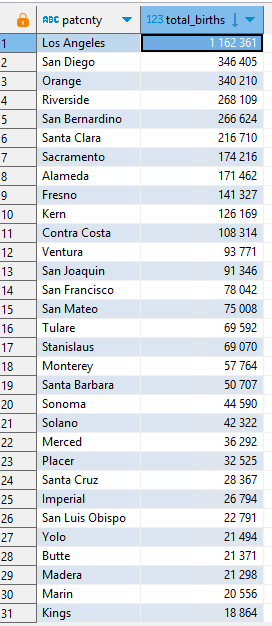


Группировка по категориям рожениц и годам

In [ ]:
   CREATE VIEW meyerczeslaw.births_by_age_group AS
SELECT
    year,
    patcnty,
    agegrp,
    SUM(count) AS total_by_age_group
FROM
    meyerczeslaw.inhospitalbirthsbyagegroup
WHERE
    agegrp != 'Total Births'
GROUP BY
    year, patcnty, agegrp
ORDER BY
    year, patcnty, agegrp;

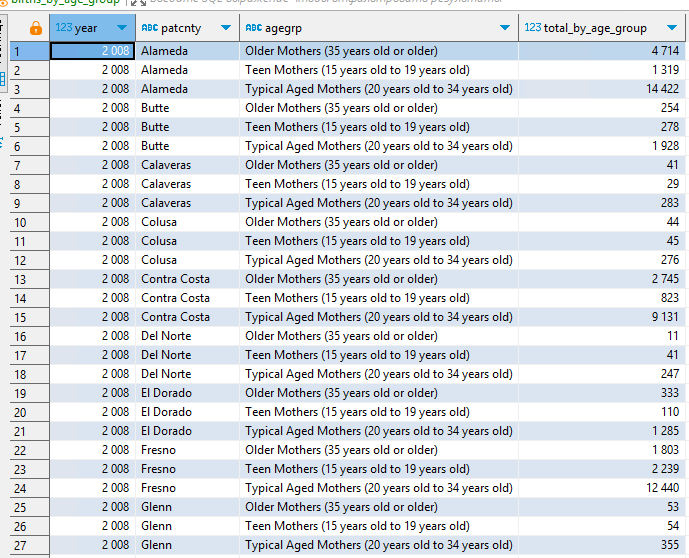



Среднее количество рождений по категориям матерей в округах


In [ ]:
CREATE VIEW meyerczeslaw.avg_births_by_age_group AS
SELECT
    patcnty,
    agegrp,
    AVG(count) AS avg_births
FROM
    meyerczeslaw.inhospitalbirthsbyagegroup
WHERE
    agegrp != 'Total Births'
GROUP BY
    patcnty, agegrp
ORDER BY
    patcnty, agegrp;



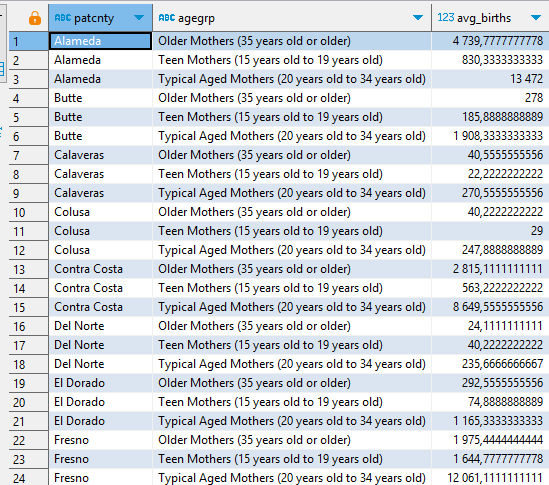

[Дашборд в Суперсете](http://dv.dp.local/superset/dashboard/p/kvMLJQrWJZ1/)

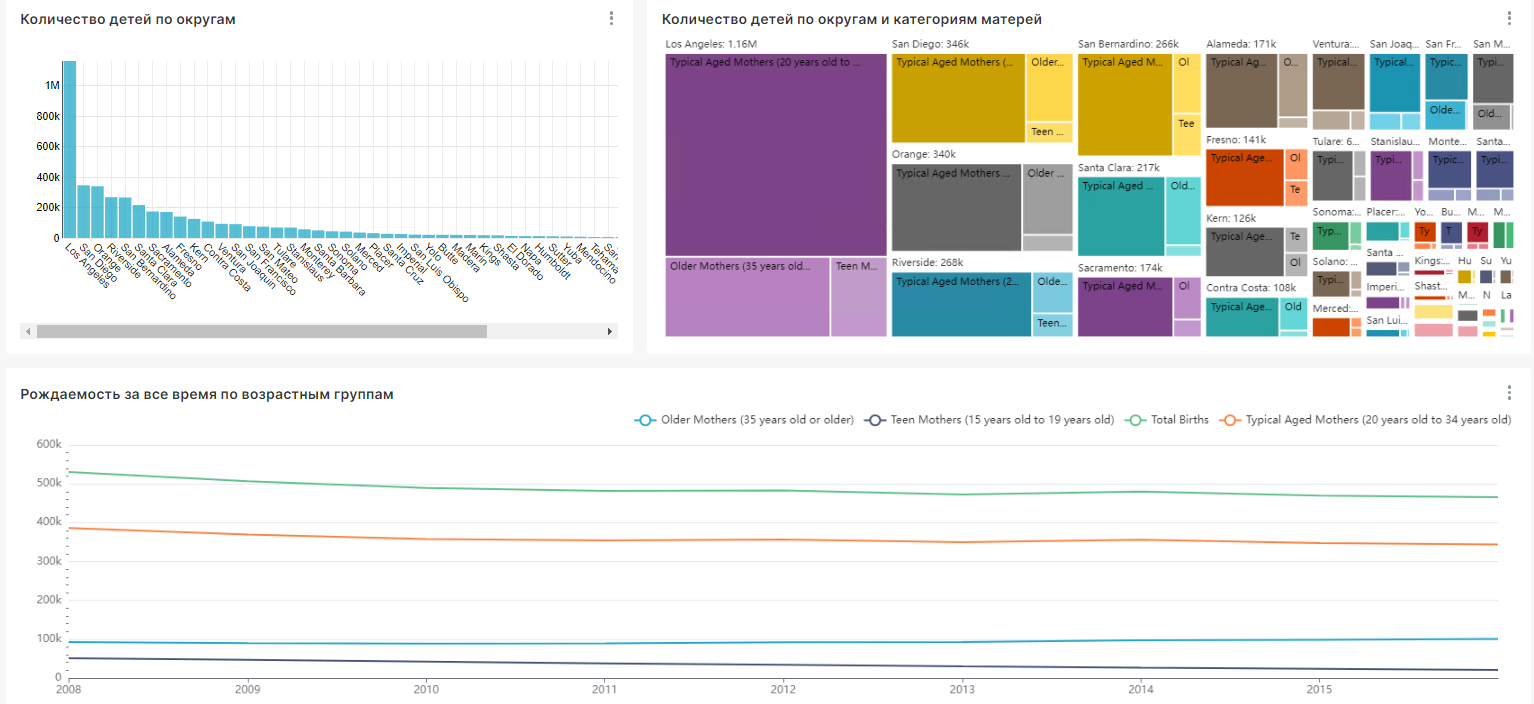

### Лаборатная работа №8

1) в вашей предварительно созданной схеме (schema) в базе данных из
лабораторной работы №1 необходимо создать таблицу test со столбцами
{A integer ,B integer , C integer}.

Сгенерируйте 1000 случайных строк и значений в указанную таблицу любыми
способами (например используя метод generate_series как мы это
использовали в лекции)

Создайте все возможные комбинации B Tree индексов для столбцов A / B / C
- индекс на столбце A
- индекс на столбцах А и B
- индекс на столбцах B и A
- индекс на столбцах A и C
- …
- индекс на столбцах A, B и C
- индекс на столбцах B, A и C
- …

Создайте Advanced Statistics для столбцов A, B, C командой `CREATE STATISTICS …`

Решите следующую задачу:

    Узнайте какой из созданных вами индексов полностью покрывает SQL
    запрос ниже?

    `SELECT min(A) OVER(PARTITION BY B,C ORDER BY B,C)
    FROM test
    WHERE A = ??? (любой существующее значение)
    ORDER BY C,B`

    для понимания какой индекс покрывает SQL запрос - обратитесь в
    системную таблицу pg_stat_user_indexes,
    выполните данный запрос несколько десятков раз или запустите pgbench
    (как нагрузочное тестирование)

Прикладываемый артефакт к работе: SQL команды для формирования
таблицы / Advanced Statistics, скриншот результата запроса к
pg_stat_user_indexes после выполнения нагрузки в рамках SQL запроса и ваш
ответ выбора индекса из созданных


Создаем таблицу, генерируем числа.

In [ ]:
CREATE TABLE meyerczeslaw.test (
    A INTEGER,
    B INTEGER,
    C INTEGER);

INSERT INTO meyerczeslaw.test (A, B, C)
SELECT
    (RANDOM() * 1000)::INTEGER,
    (RANDOM() * 100)::INTEGER,
    (RANDOM() * 100)::INTEGER
FROM generate_series(1, 1000);


Создаем все возможные комбинации индексов.

In [ ]:
CREATE INDEX idx_a ON meyerczeslaw.test (A);
CREATE INDEX idx_b ON meyerczeslaw.test (B);
CREATE INDEX idx_c ON meyerczeslaw.test (C);

CREATE INDEX idx_a_b ON meyerczeslaw.test (A, B);
CREATE INDEX idx_b_a ON meyerczeslaw.test (B, A);
CREATE INDEX idx_a_c ON meyerczeslaw.test (A, C);
CREATE INDEX idx_c_a ON meyerczeslaw.test (C, A);
CREATE INDEX idx_b_c ON meyerczeslaw.test (B, C);
CREATE INDEX idx_c_b ON meyerczeslaw.test (C, B);

CREATE INDEX idx_a_b_c ON meyerczeslaw.test (A, B, C);
CREATE INDEX idx_a_c_b ON meyerczeslaw.test (A, C, B);
CREATE INDEX idx_b_a_c ON meyerczeslaw.test (B, A, C);
CREATE INDEX idx_b_c_a ON meyerczeslaw.test (B, C, A);
CREATE INDEX idx_c_a_b ON meyerczeslaw.test (C, A, B);
CREATE INDEX idx_c_b_a ON meyerczeslaw.test (C, B, A);


Создание статистики

In [ ]:
CREATE STATISTICS test_stats (dependencies, ndistinct) ON A, B, C FROM meyerczeslaw.test;


Запрос для определения покрытия индекса

In [ ]:
SELECT min(A) OVER (PARTITION BY B, C ORDER BY B, C)
FROM meyerczeslaw.test
WHERE A = 73
ORDER BY C, B;


Вызов результата

In [ ]:
SELECT * FROM pg_stat_user_indexes WHERE relname = 'test';


Как мы видим, результат мне дал индекс a_b_c. При запуске несколько раз результат не меняется.

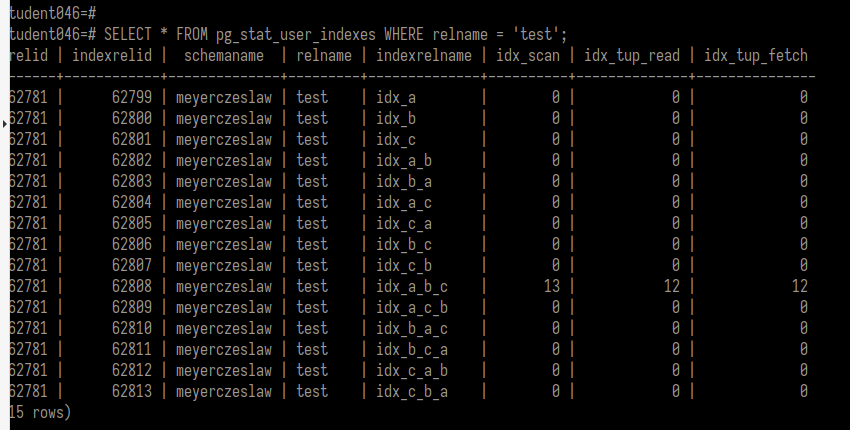

### Промежуточная аттестация №2

1) сделайте импорт в вашу предварительно созданную схему (schema) в базе
данных, представленных данных о телеметрии оборудования и об НСИ
справочниках.
Предоставляются два файла
- приборы работающие в “зеленой зоне”.
ВНИМАНИЕ! В рамках Лабораторной работы №5 вы уже делали импорт
данного файла в вашу схему (если у вас по каким либо причинам данных
нет - то необходимо проимпортировать их заново любым удобным вам
способом)
- НСИ данные (справочные данные) , которые представлены в файле “XLS
справочник”

Модель данных НСИ файла:
- Столбец “Идентификатор” - уникальный номер прибора, сопоставленный
с номером прибора из файла “зеленой зоны”
- Столбец “Позиция прибора” - уникальное имя прибора в каталогизаторе
- Столбец “Описание” - описание измерительного прибора
- Столбец “Тип значения” - указанное тип значения для прибора
- Столбец “Единица измерения” - единица измерения значений прибора
- Столбец “min” - возможное минимальное значение прибора
- Столбец “max” - возможное максимальное значение прибора

Решите следующие задачи:
- Загрузите НСИ данные из XLS файла в вашу схему базы данных
используя созданный вами скрипт на языке программирования Python
(используя пакет pg8000). Если вы используете базу данных РТК, то
необходимо созданный Python скрипт запускать на Операционной
Системе где расположена База Данных. (если у вас есть возможность то
обратитесь к цифровому GPT-ассистенту для генерации Python скрипта)
- Напишете SQL запрос, который выводит “значение прибора”, “дату
значения”, “Описание прибора” и “единицу измерения”. Условный пример
находится ниже. Отсортируйте результат по убыванию “даты значения” и
затем по “описанию прибора”

Описание прибора   Значение   Дата   единица измерения

Регулятор расхода сырья дебутанизатора в С-1   16588.29992   2022-10-19 21:00:34.000 +0300   кг/ч
… … … …
- Создайте необходимые B-Tree индексы которые по вашему мнению
необходимы для оптимизации SQL запроса выше (возможно индексов
может быть несколько и разных видов )
Прикладываемый артефакт к работе: SQL команды (таблиц / индексов / SQL
операции) + Python скрипт, решающие задачи и скриншоты результатов для
подтверждения работы.
Если вы использовали GPT-ассистента, то приложите ваш PROMT запрос к ИИ.


Так как первая таблица уже была закачана, работал только со второй.

Хотя ИИ пользовался, код не приведу, так было много мелких вопросов.

Загрузка файла для скачивания на сервер

In [ ]:
wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1UIbO5fETn9u76_euSa3ylXVO6f70O3zH' -O script.py

Создание скрипта на Python для создания таблицы и вставки в неё данных на PG8000.

In [ ]:
import pandas as pd
import pg8000

# Открытие файла
file_path = 'google_sheets_data.csv'
data = pd.read_csv(file_path)

# Замена запятых для правильного формата
data['min'] = data['min'].str.replace(',', '.').astype(float)
data['max'] = data['max'].str.replace(',', '.').astype(float)

# Подключение к базе данных PostgreSQL через pg8000
conn = pg8000.connect(user="student046", password="ma2Uoqu6ju0v", host="192.168.77.5", database="student046", port = 5432)

cursor = conn.cursor()

# Создание таблицы, если она не существует
cursor.execute("""
CREATE TABLE IF NOT EXISTS meyerczeslaw.app_data (
идентификатор INT,
позиция_приборов VARCHAR(255),
описание TEXT,
тип_значения VARCHAR(50),
единица_измерения VARCHAR(50),
min NUMERIC,
max NUMERIC );
""")

# Вставка данных в таблицу
for index, row in data.iterrows():
    cursor.execute("""
        INSERT INTO meyerczeslaw.app_data (идентификатор, позиция_приборов, описание, тип_значения, единица_измерения, min, max)
        VALUES (%s, %s, %s, %s, %s, %s, %s);
        """,
        row['Идентификатор'], row['Позиция прибора'], row['Описание'], row['Тип значения'], row['Единица измерения'], row['min'], row['max']))

conn.commit()
cursor.close()
conn.close()

Код для запроса необходимых данных


<details>
<summary>Скрипт для ИИ:</summary>
Итак, у нас есть данные в таблице meyerczeslaw.green_zone
device_id |  timestamp_unix  |    value    
-----------+------------------+-------------
         1 | 1666200364421000 | 16882.26501
         2 | 1666200364421000 |     0.00000
         3 | 1666200364421000 |   552.72654
         4 | 1666200364421000 |   576.82428
         5 | 1666200364421000 |   576.82428
         6 | 1666200364421000 |   603.83035
         7 | 1666200364421000 |   639.43478
         8 | 1666200364421000 |    62.61051
         9 | 1666200364421000 |    27.00607
        10 | 1666200364421000 |    35.60444

И данные с таблицы  meyerczeslaw.app_data

 идентификатор | позиция_приборов |                   описание                   | тип_значения | единица_измерения |   min   |   max   
---------------+------------------+----------------------------------------------+--------------+-------------------+---------+---------
             1 | FIRCA-001        | Регулятор расхода сырья дебутанизатора в С-1 | PV           | кг/ч              | 14750.0 | 19750.0
             2 | FIRC-003         | Регулятор расхода резервного сырья в С-1     | PV           | кг/ч              | 14750.0 | 19750.0
             3 | PZSA-111         | Давление шлемовой трубы С-1                  | PV           | КПа               |   500.0 |   600.0
             4 | PIRCA-001        | Регулятор давления сверху С-1                | PV           | КПа               |   500.0 |   600.0
             5 | PIR-107А         | Давление сверху колонны                      | PV           | КПа               |   500.0 |   600.0
             6 | PIR-107B         | Давление на тарелке питания                  | PV           | КПа               |   500.0 |   680.0
             7 | PIR-107С         | Давление в кубе колонны                      | PV           | КПа               |   500.0 |   680.0
             8 | PDIRA-107С       | Перепад между верхом и кубом                 | PV           | КПа               |     0.0 |    33.0
             9 | PDIRA-107A       | Перепад между верхом и тарелкой питания      | PV           | КПа               |     0.0 |    70.0
            10 | PDIRA-107В       | Перепад между  тарелкой питания и кубом      | PV           | КПа               |     0.0 |    33.0


Мне нужно получить:
Описание с app_data как Описание прибора,
value     с green_zone как как Значение,
timestamp_unix  с green_zone как Дата (формат даты),
единица_измерения  с app_data как единица
измерения
</details>


In [ ]:
SELECT
    a.описание AS "Описание прибора",
    g.value AS "Значение",
    TO_TIMESTAMP(g.timestamp_unix / 1000000) AS "Дата",
    a.единица_измерения AS "Единица измерения"
FROM
    meyerczeslaw.green_zone g
JOIN
    meyerczeslaw.app_data a ON g.device_id = a.идентификатор
ORDER BY
    "Дата" DESC,
    "Описание прибора" ASC
LIMIT 10;

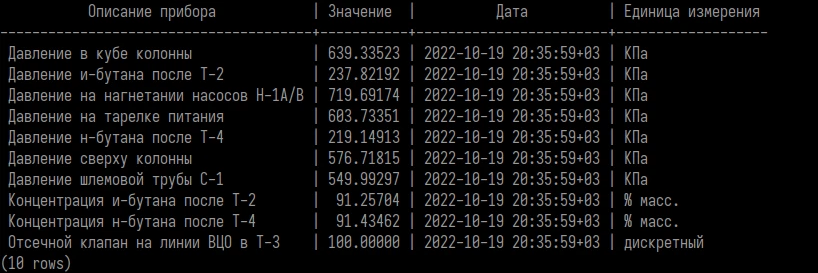



Создание индексов

<details>
<summary>Код для ИИ</summary>
Создай необходимые B-Tree индексы для оптимизации запроса.
</details>


In [ ]:
-- Индекс на device_id в таблице green_zone
CREATE INDEX idx_green_zone_device_id ON meyerczeslaw.green_zone (device_id);

-- Индекс на идентификатор в таблице app_data
CREATE INDEX idx_app_data_id ON meyerczeslaw.app_data (идентификатор);

-- Индекс на timestamp_unix в таблице green_zone
CREATE INDEX idx_green_zone_timestamp ON meyerczeslaw.green_zone (timestamp_unix);

-- Индекс на описание в таблице app_data
CREATE INDEX idx_app_data_description ON meyerczeslaw.app_data (описание);


### Итоговая работа

Необходимо выбрать один из представленных наборов данных ниже

Статистика о сне и здоровье
https://www.kaggle.com/datasets/hanaksoy/health-and-sleep-statistics


Сделайте следующие задания

1) любым удобным вам техническим способом (DBeaver, Python или используя AI)
загрузите набор данных в вашу схему базы данных

2) нормализуйте выбранную модель данных, выделив из оригинальных данных
таблицы справочники и таблицу оперативных данных. Укажите необходимые
Внешние / Уникальные ключи и необходимые индексы.
Здесь , возможно вам понадобится определенный тип таблицы (PARTITIONED,
INHERITED, CLUSTERED, …) и определенные типы индексов в рамках
семейства BTree. (Возможно объем данных не такой большой - но постарайтесь
заложить эту функциональность)

3) создайте табличные триггеры только на справочных таблицах для CRUD
операций по аудиту любых изменений для сохранения истории изменений

4) напишите одну pl/pgsql функцию, которая возвращает аудит изменений по
указанной в параметре справочной таблице в виде табличных данных,
например
SELECT * FROM fnc_audit(‘справочник1’)
Дата изменения Примененная операция Измененные данные
2024-10-19 21:00:34 INSERT … … … …

5) подготовьте 3 интересных по вашему мнению инсайта из данных в виде SQL
выражений, выраженных в VIEW или MATERIALIZED VIEW в вашей схеме
данных и визуализированных в инструменте RT.DataVision


Артефакты финальной аттестации:

1) Весь исходный код указанных заданий + скриншоты демонстрирующие
работу вашего решения в виде приложенного DOC / DOCX файла на
учебную Платформу.

2) На защиту вашего решения требуется презентация не более 5 слайдов с
- указанием темы выбранного набора данных
- представлением Вас
- интересные моменты / находки которые вы сделали в коде (
например использовали AI для генерации дополнительных
данных)
- скриншоты визуализаций в RT.DataVision



**Создание таблиц**

In [ ]:
-- Удаление временной таблицы, если она существует

DROP TABLE IF EXISTS meyerczeslaw.temp_sleep_data;


-- Создание и загрузка данных во временную таблицу

CREATE TABLE meyerczeslaw.temp_sleep_data (
    "User ID" SERIAL PRIMARY KEY,
    "Age" INT,
    "Gender" CHAR(1),
    "Sleep Quality" INT,
    "Bedtime" TIME,
    "Wake-up Time" TIME,
    "Daily Steps" INT,
    "Calories Burned" INT,
    "Physical Activity Level" VARCHAR(10),
    "Dietary Habits" VARCHAR(10),
    "Sleep Disorders" VARCHAR(3),
    "Medication Usage" VARCHAR(3));


-- *Тут происходит импорт данных через DBeaber*

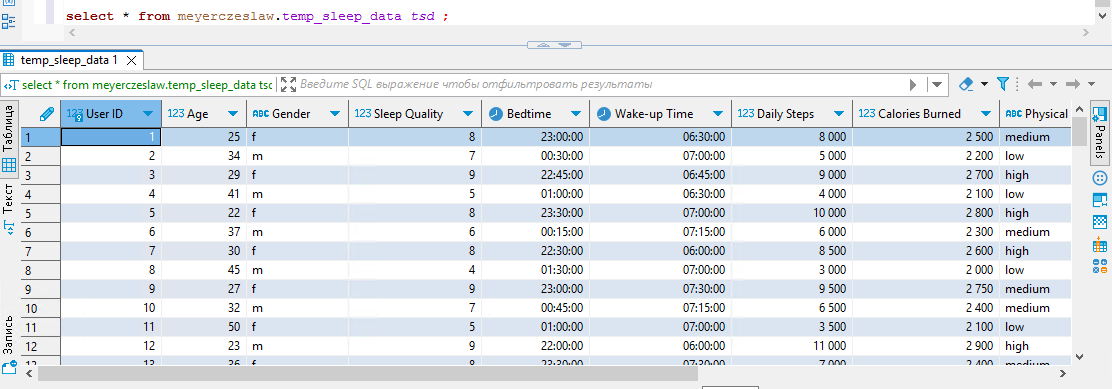



In [ ]:
-- Удаление таблиц-справочников, если они существуют

DROP TABLE IF EXISTS meyerczeslaw.gender CASCADE;
DROP TABLE IF EXISTS meyerczeslaw.physical_activity_level CASCADE;
DROP TABLE IF EXISTS meyerczeslaw.dietary_habits CASCADE;


-- Создание таблиц-справочников

CREATE TABLE meyerczeslaw.gender (
    gender_id SERIAL PRIMARY KEY,
    gender CHAR(1) UNIQUE);

CREATE TABLE meyerczeslaw.physical_activity_level (
    activity_level_id SERIAL PRIMARY KEY,
    activity_level VARCHAR(10) UNIQUE);

CREATE TABLE meyerczeslaw.dietary_habits (
    habits_id SERIAL PRIMARY KEY,
    habits VARCHAR(10) UNIQUE);


-- Вставка данных в таблицы-справочники

INSERT INTO meyerczeslaw.gender (gender)
SELECT DISTINCT "Gender"
FROM meyerczeslaw.temp_sleep_data;

INSERT INTO meyerczeslaw.physical_activity_level (activity_level)
SELECT DISTINCT "Physical Activity Level"
FROM meyerczeslaw.temp_sleep_data;

INSERT INTO meyerczeslaw.dietary_habits (habits)
SELECT DISTINCT "Dietary Habits"
FROM meyerczeslaw.temp_sleep_data;

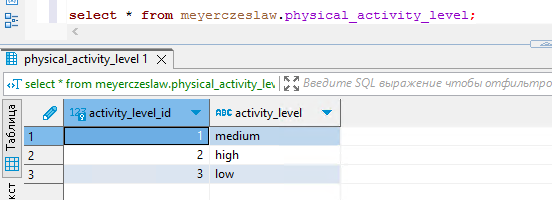

In [ ]:
-- Удаление рабочей таблицы, если она существует

DROP TABLE IF EXISTS meyerczeslaw.sleep_data;


-- Создание и вставка данных в основную рабочую таблицу

CREATE TABLE meyerczeslaw.sleep_data AS
SELECT
    t."User ID",
    t."Age",
    g.gender,
    t."Sleep Quality",
    t."Bedtime",
    t."Wake-up Time",
    t."Daily Steps",
    t."Calories Burned",
    p.activity_level_id,
    d.habits_id,
    CASE
        WHEN t."Sleep Disorders" = 'yes' THEN 1
        ELSE 0
    END AS "Sleep Disorders",
    CASE
        WHEN t."Medication Usage" = 'yes' THEN 1
        ELSE 0
    END AS "Medication Usage"
FROM meyerczeslaw.temp_sleep_data t
JOIN meyerczeslaw.gender g ON t."Gender" = g.gender
JOIN meyerczeslaw.physical_activity_level p ON t."Physical Activity Level" = p.activity_level
JOIN meyerczeslaw.dietary_habits d ON t."Dietary Habits" = d.habits;


-- Удаление временной таблицы

 DROP TABLE meyerczeslaw.sleep_data;

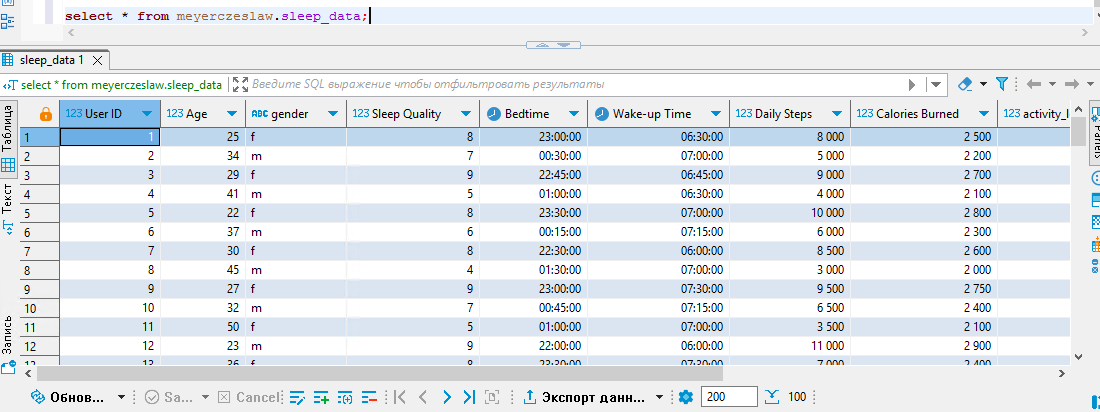

In [ ]:
-- Создание VIEW для дашборда

CREATE OR REPLACE VIEW meyerczeslaw.vw_sleep_data AS
SELECT
    sd."User ID",
    sd."Age",
    g.gender AS "Gender",
    sd."Sleep Quality",
    sd."Bedtime",
    sd."Wake-up Time",
    sd."Daily Steps",
    sd."Calories Burned",
    pal.activity_level AS "Physical Activity Level",
    dh.habits AS "Dietary Habits",
    CASE
        WHEN sd."Sleep Disorders" = 1 THEN 'Yes'
        ELSE 'No'
    END AS "Sleep Disorders",
    CASE
        WHEN sd."Medication Usage" = 1 THEN 'Yes'
        ELSE 'No'
    END AS "Medication Usage"
FROM meyerczeslaw.sleep_data sd
JOIN meyerczeslaw.gender g ON sd.gender = g.gender
JOIN  meyerczeslaw.physical_activity_level pal ON sd.activity_level_id = pal.activity_level_id
JOIN  meyerczeslaw.dietary_habits dh ON sd.habits_id = dh.habits_id;

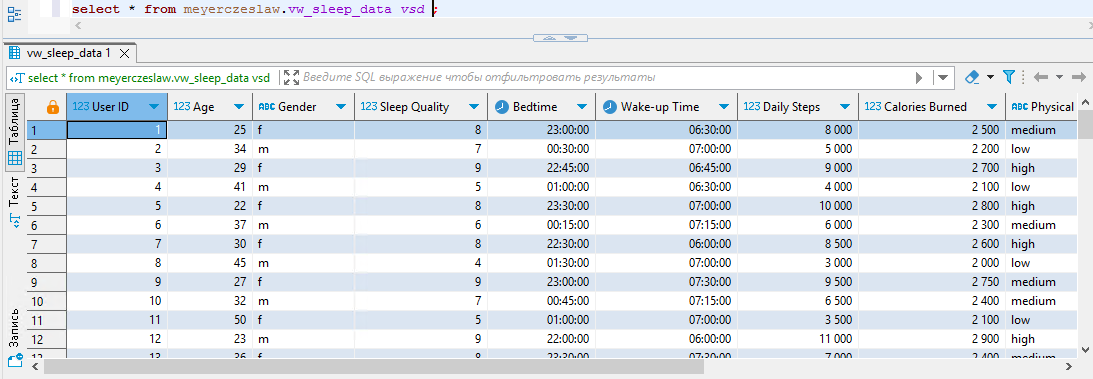

**Создание индексов и внешних ключей**

In [ ]:
-- Создание индексов

CREATE INDEX idx_sleep_data_age ON meyerczeslaw.sleep_data ("Age");
CREATE INDEX idx_sleep_data_daily_steps ON meyerczeslaw.sleep_data ("Daily Steps");
CREATE INDEX idx_sleep_data_calories ON meyerczeslaw.sleep_data ("Calories Burned");


-- Добавление внешних ключей

ALTER TABLE meyerczeslaw.sleep_data
ADD CONSTRAINT fk_gender FOREIGN KEY (gender_id) REFERENCES meyerczeslaw.gender (gender_id),
ADD CONSTRAINT fk_activity_level FOREIGN KEY (activity_level_id) REFERENCES meyerczeslaw.physical_activity_level (activity_level_id),
ADD CONSTRAINT fk_dietary_habits FOREIGN KEY (habits_id) REFERENCES meyerczeslaw.dietary_habits (habits_id);

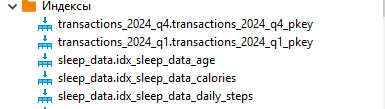

**Создание таблицы для аудита, триггеров.**

In [ ]:
-- Создание таблицы для аудита

CREATE TABLE meyerczeslaw.audit_log (
    audit_id SERIAL PRIMARY KEY,
    table_name VARCHAR(50),
    operation_type VARCHAR(10),  -- INSERT, UPDATE, DELETE
    changed_data JSONB,
    change_timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP);


-- Создание триггерной функции

CREATE OR REPLACE FUNCTION meyerczeslaw.fnc_log_audit()
RETURNS TRIGGER AS $$
BEGIN
    IF TG_OP = 'INSERT' THEN
        INSERT INTO meyerczeslaw.audit_log (table_name, operation_type, changed_data)
        VALUES (TG_TABLE_NAME, TG_OP, row_to_json(NEW));
        RETURN NEW;
    ELSIF TG_OP = 'UPDATE' THEN
        INSERT INTO meyerczeslaw.audit_log (table_name, operation_type, changed_data)
        VALUES (TG_TABLE_NAME, TG_OP, jsonb_build_object('old', row_to_json(OLD), 'new', row_to_json(NEW)));
        RETURN NEW;
    ELSIF TG_OP = 'DELETE' THEN
        INSERT INTO meyerczeslaw.audit_log (table_name, operation_type, changed_data)
        VALUES (TG_TABLE_NAME, TG_OP, row_to_json(OLD));
        RETURN OLD;
    END IF;
END;
$$ LANGUAGE plpgsql;


-- Создание триггеров для каждой таблицы

CREATE TRIGGER trg_audit_gender
AFTER INSERT OR UPDATE OR DELETE ON meyerczeslaw.gender
FOR EACH ROW EXECUTE FUNCTION meyerczeslaw.fnc_log_audit();

CREATE TRIGGER trg_audit_activity_level
AFTER INSERT OR UPDATE OR DELETE ON meyerczeslaw.physical_activity_level
FOR EACH ROW EXECUTE FUNCTION meyerczeslaw.fnc_log_audit();

CREATE TRIGGER trg_audit_dietary_habits
AFTER INSERT OR UPDATE OR DELETE ON meyerczeslaw.dietary_habits
FOR EACH ROW EXECUTE FUNCTION meyerczeslaw.fnc_log_audit();


-- Создание функции для отображения изменений

CREATE OR REPLACE FUNCTION meyerczeslaw.fnc_audit(table_name_param VARCHAR)
RETURNS TABLE (
    change_timestamp TIMESTAMP,
    operation_type VARCHAR,
    changed_data JSONB
) AS $$
BEGIN
    RETURN QUERY
    SELECT a.change_timestamp, a.operation_type, a.changed_data
    FROM meyerczeslaw.audit_log a
    WHERE a.table_name = table_name_param
    ORDER BY a.change_timestamp DESC;
END;
$$ LANGUAGE plpgsql;



In [ ]:
-- Проверка работы

INSERT INTO meyerczeslaw.gender (gender) VALUES ('T'); -- Добавление новой записи

UPDATE meyerczeslaw.gender
SET gender = 'M'
WHERE gender_id = 3;  -- Изменение записи

DELETE FROM meyerczeslaw.gender WHERE gender_id = 3; -- Удаление записи

SELECT * FROM meyerczeslaw.fnc_audit('gender'); -- Вывод состояния

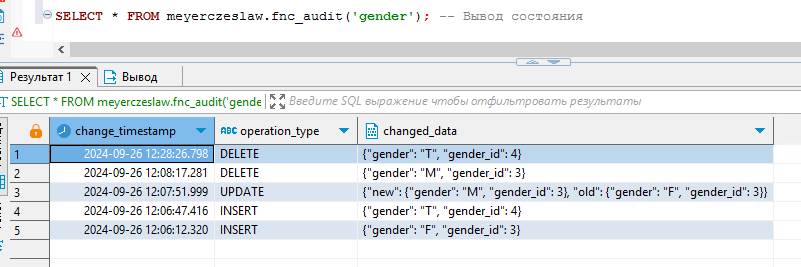

**Дашборд**

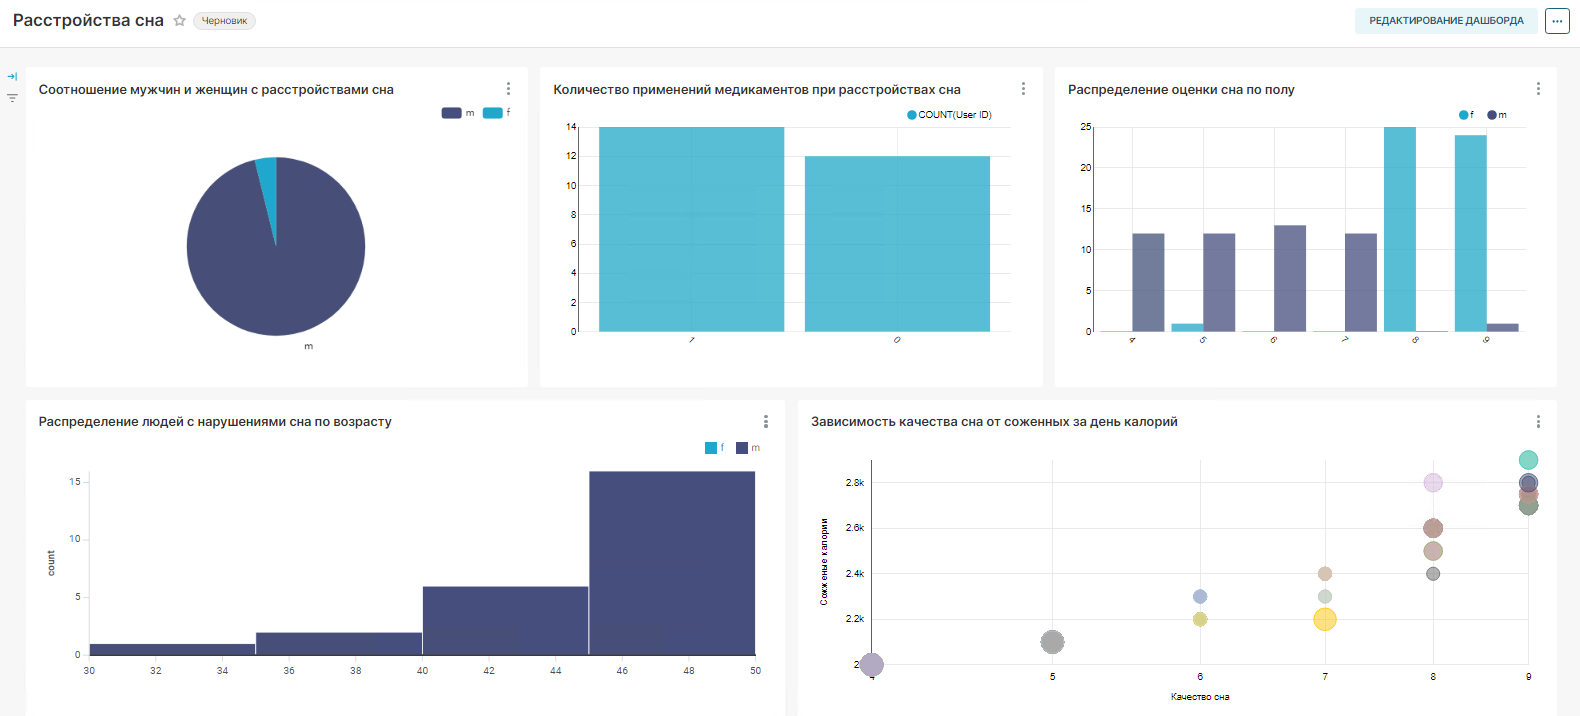